<h1>Fast Experimentation in Amazon SageMaker Studio Notebooks</h1>

## Workshop overview

In this workshop, you will go through an end-to-end machine learning process. You will use the "AI4I 2020 Predictive Maintenance Dataset" from the UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset, which contains information about machine failures, to train a binary classification model that predicts whether a machine will fail based on input data.

In module 2 (this module), you will perform data exploration and fast experimentation in a familiar Jupyter Notebook environment using SageMaker Studio notebooks. In module 3, you move the transformations you used in module 2 to a separate python script and use SageMaker Processing Jobs to perform feature engineering. In module 4, you use SageMaker XGBoost algorithm to train your model. You will then deploy a SageMaker Inference Pipeline endpoint consisting of Feature Transformer and XGBoost steps for real-time inference in module 5, and deploy an API endpoint for the consumers using Amazon API Gateway and AWS Lambda in module 6. You perform inference by invoking the API endpoint in module 7. You will use SageMaker Experiments throughout the process to track the experiment steps. Finally, in module 8, you create a workflow for the end-to-end process by using Amazon SageMaker Pipelines.






## In this notebook...

You will explore the data and use SKLearn Feature Transformers to preprocess the data. You then train the model and use the trained model to perform inference in the same notebook.

You will use SageMaker Experiments to track the fast experimentation steps.


## Environment set up 

Start by installing the xgboost python package.

In [2]:
%pip install -q xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q sagemaker-experiments

Note: you may need to restart the kernel to use updated packages.


Retreive information about the default session Amazon S3 bucket for storing training data, and the IAM role that provides the required permissions.

In [4]:
import sagemaker
import boto3
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
s3_prefix = 'sm-fast-iteration'

print(region)
print(role)
print(bucket_name)

eu-west-1
arn:aws:iam::009319036446:role/service-role/AmazonSageMakerExecutionRole-mlendtoend-vpcmode-sagemaker
sagemaker-eu-west-1-009319036446


Download the dataset

In [21]:
import urllib
import os

data_dir = '/opt/ml/data'
if not os.path.exists(data_dir):
        os.makedirs(data_dir)
file_path = os.path.join(data_dir, 'predmain_raw_data_header.csv')
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
urllib.request.urlretrieve(dataset_url, file_path)

('/opt/ml/data/predmain_raw_data_header.csv',
 <http.client.HTTPMessage at 0x7fd5c2e4a440>)

# Data Preprocessing & Feature Engineering

### Data Exploration

Find out how many samples and columns are included in the dataset.

In [6]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(file_path)

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (10000, 14)


Preview the first 10 rows.

In [7]:
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


Check the data types for each column and identify columns with missing values

In [8]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


List the possible values for the "Machine failure" column and frequency of their occurence over the entire dataset.

In [9]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

Plot the target columns to visualise the distribution of values.

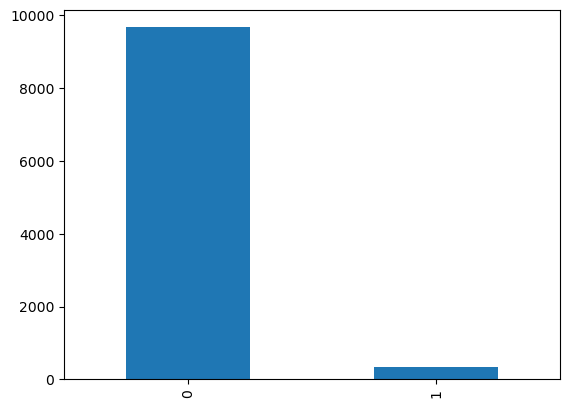

In [10]:
import matplotlib.pyplot as plt

df['Machine failure'].value_counts().plot.bar()
plt.show()

We have discovered that the dataset is quite unbalanced. However, we are not going to balance it in this workshop.

Drop the attributes you are not interested in and keep only the numeric attributes.

In [11]:
df1 = df.sample(frac =.1)
df1 = df1.drop(['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).select_dtypes(include='number')
df1.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
7804,299.9,311.4,1480,44.9,108,0
487,297.4,309.1,1463,35.0,183,0
6762,301.4,310.8,1362,53.2,4,0
1213,296.8,307.8,1551,38.9,112,0
9569,299.8,311.0,1948,20.0,185,0


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 7804 to 2711
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      1000 non-null   float64
 1   Process temperature [K]  1000 non-null   float64
 2   Rotational speed [rpm]   1000 non-null   int64  
 3   Torque [Nm]              1000 non-null   float64
 4   Tool wear [min]          1000 non-null   int64  
 5   Machine failure          1000 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 54.7 KB


Use a pair plot to spot correlations.

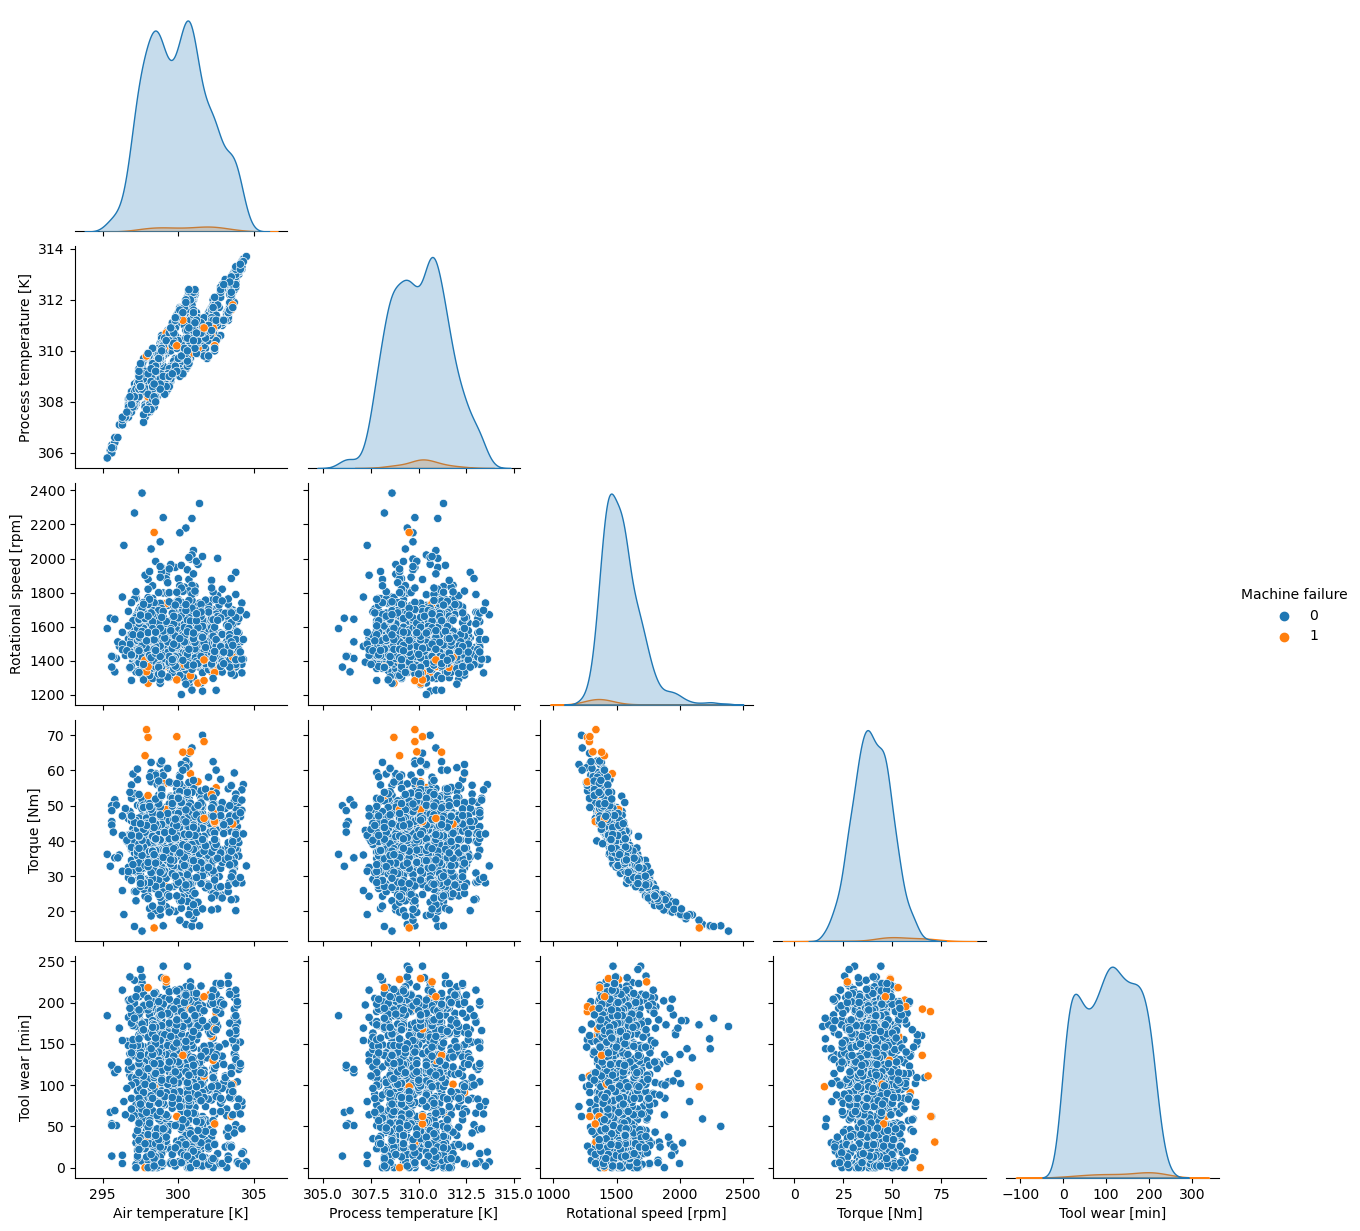

In [13]:
import seaborn
import matplotlib.pyplot as plt

seaborn.pairplot(df1, hue='Machine failure', corner=True)
plt.show()

To keep the data exploration step short during the workshop, no additional queries are included. However, feel free to explore the dataset more if you have time.

<h2>Preprocessing and Feature Engineering</h2>

### Experiment set up

Even though you are in the fast experimentation stage, it is still a good idea to track the experiments. You will leverage Amazon SageMaker Experiments to track the experimentations during training.

To do so, we need to create an _experiment_ and a new _trial_ for that experiment. A trial is a collection of training steps involved in a single training job such as preprocessing, training, model evaluation, etc. A trial contains also metadata for inputs (e.g. algorithm, parameters, data sets) and outputs (e.g. models, checkpoints, metrics). Each stage in a trial constitutes a trial component. If  you would like to read more about SageMaker experiments, see also https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html

Let's import our utility script, which will help us easily manage our experiments.

In [14]:
import sys
sys.path.append("source_dir")
from experimentutils import *

We begin with creating an experiment, or loading one if it already exists.

In [15]:
experiment_name = createExperiment("sm-fast-iteration-exp", "ML development and fast iteration with SageMaker")

Creating experiment sm-fast-iteration-exp-1678440864


From now on, we will use the above experiment to start tracking our processing and training trials. Let's create a new trial and associate it with our experiment.

In [16]:
trial_name = createTrial(experiment_name, "exp-tracking-trial-xgboost", s3_prefix)
print(trial_name)

Creating trial, exp-tracking-trial-xgboost-1678440867
exp-tracking-trial-xgboost-1678440867


Since you are performing fast experimentation, you can use the local copy of the dataset for preprocessing and training. However, to track your experimentation, it is a good idea to store it in an Amazon S3 bucket.

In [19]:
raw_data_key = '{0}/data/raw'.format(s3_prefix)
s3_raw_data = sagemaker_session.upload_data(file_path,bucket_name,key_prefix=raw_data_key)

### Data Processing

We are now ready to continue the with data processing and feature engineering tasks. We will hot encode some of the categorical columns and fill in some NaN values based on domain knowledge. Once the SKLearn fit() and transform() are done, we split our dataset into train & validation and then save the outputs to Amazon S3. We will capture this step as the first trial component of our trial. For more details on the CreateTrialComponent API call, check out https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrialComponent.html

# NEW SECTION

In [ ]:
import argparse
import os
import warnings

import pandas as pd
import tarfile
from pathlib import Path

import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [ ]:
columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']
cat_columns = ['Type']
num_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
target_column = 'Machine failure'


In [17]:
output_path = "/opt/ml/processing"

In [18]:
process_trial_comp = createTrialComponent(trial_name,"trial-comp-preprocess", s3_prefix, file_path, train_features_output_path, val_features_output_path, model_joblib_path, parameters)

/opt/ml/data/predmain_raw_data_header.csv
Splitting data into train and test sets with ratio 0.1
Train features shape after preprocessing: (7200, 8)
Validation features shape after preprocessing: (800, 8)
Testing features shape after preprocessing: (800, 8)
/opt/ml/processing
Saving to /opt/ml/processing/train_features.csv
Saving to /opt/ml/processing/train_labels.csv
Saving to /opt/ml/processing/val_features.csv
Saving to /opt/ml/processing/val_labels.csv
Saving to /opt/ml/processing/test_features.csv
Saving to /opt/ml/processing/test_labels.csv
Uploading to s3 at s3://sagemaker-eu-west-1-009319036446/sm-fast-iteration
Creating trial component trial-comp-preprocess-1678440888 for trial exp-tracking-trial-xgboost-1678440867


Let's also take a look at our processed training dataset.

In [ ]:
import pandas as pd
df = pd.read_csv(train_features_output_path)
df.head(10)

We can see that the categorical variables have been one-hot encoded, and you are free to check that we do not have NaN values anymore as expected.


### Experiment Analytics

We can visualize the experiment analytics either from Amazon SageMaker Studio Experiments plug-in or using the sagemaker SDK as per below.

In [ ]:
from sagemaker.experiments.run import Run, load_run
from sklearn.metrics import roc_auc_score

In [ ]:
from sagemaker.analytics import ExperimentAnalytics
experiment = ExperimentAnalytics(experiment_name=experiment_name)
experiment.dataframe()

## Model Training

In this part, we will use xgboost to train a simple binary classification model, using the pre-processed data generated in the previous step by the processing job. We will create a new trial component each time we start the training and will record the hyperparameter values and the results.

In [ ]:
model_path = "/opt/ml/model"

In [ ]:
eta = 0.3
%run -i source_dir/xgboost_training.py --eta $eta
parameters={
            'eta': {
                'NumberValue': eta
            }
}
training_trial_comp = createTrialComponent(trial_name,"trial-comp-xgboost", s3_prefix, file_path, 
                                           train_features_output_path, val_features_output_path, model_path, parameters)


### Experiment analytics

Again, you can visualize your latest experiment analytics either from Amazon SageMaker Studio Experiments plug-in or using the SDK from a notebook

In [ ]:
from sagemaker.analytics import ExperimentAnalytics
experiment = ExperimentAnalytics(experiment_name=experiment_name)
experiment.dataframe()

### Using your model to generate predictions

Let's now use our model for inference.

In [ ]:
df_test_features = pd.read_csv(test_features_output_path, header=None)
df_test_labels = pd.read_csv(train_labels_output_path, header=None)
test_X = df_test_features.values
test_y = df_test_labels.values.reshape(-1)
dtest = xgboost.DMatrix(test_X, label=test_y)

model_xgb_trial = xgboost.Booster()
model_xgb_trial.load_model(model_path)
test_predictions = model_xgb_trial.predict(dtest)

In [ ]:
print ("===Metrics for Test Set===")
print('')
print (pd.crosstab(index=test_y, columns=np.round(test_predictions), 
                                 rownames=['Actuals'], 
                                 colnames=['Predictions'], 
                                 margins=True)
      )
print('')
rounded_predict = np.round(test_predictions)

accuracy = accuracy_score(test_y, rounded_predict)
precision = precision_score(test_y, rounded_predict)
recall = recall_score(test_y, rounded_predict)
print('')

print("Accuracy Model A: %.2f%%" % (accuracy * 100.0))
print("Precision Model A: %.2f" % (precision))
print("Recall Model A: %.2f" % (1 - recall))

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_y, test_predictions)
print("AUC A: %.2f" % (auc))


As SageMaker Experiments now supports common chart types to visualize model training results, we can track these granular metrics to our experiments.

In [ ]:
import smexperiments
from smexperiments.tracker import Tracker
 
with Tracker.load(trial_component_name=training_trial_comp) as tracker:
    tracker.log_precision_recall(test_y, rounded_predict)
    tracker.log_roc_curve(test_y, rounded_predict)
    tracker.log_confusion_matrix(test_y, rounded_predict)

### Clean up step (Optional)

In [ ]:
#  cleanup('ENTER_YOUR_EXPERIMENT_HERE')